#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.


Нам предстоит:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import catboost as cb
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('C:/Downloads/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


У нас два столбца: дата и количество заказов. 

Пропущенных значений в датасете нет. 

Для `datetime` необходимо поменять тип данных.

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Стобец `datetime` установим как индексы

In [7]:
data = data.set_index('datetime')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные расположим в хронологическом порядке

In [9]:
data = data.sort_index()
data.index.is_monotonic

True

Рассмотрим распределение данных

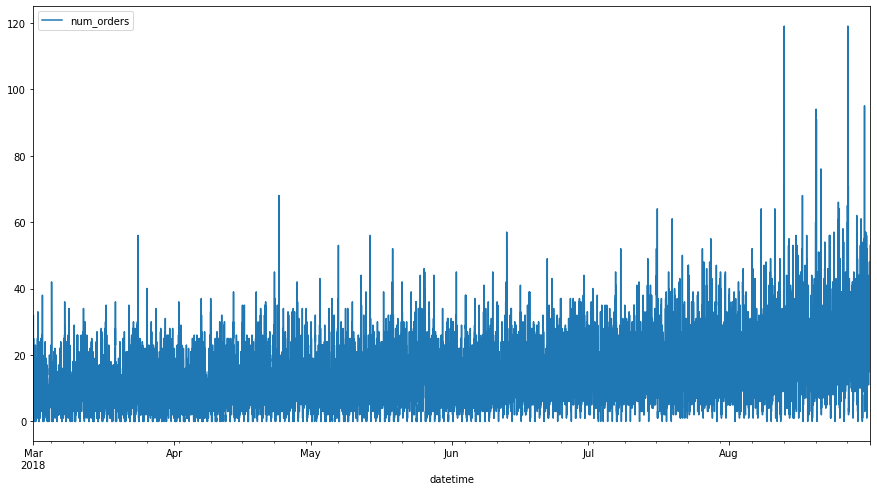

In [10]:
data.plot(figsize=(15, 8));

Судя по графику, у данных большая частота. При анализе данных построим график для меньшего периода.

Проведем ресемплирование данных по часу

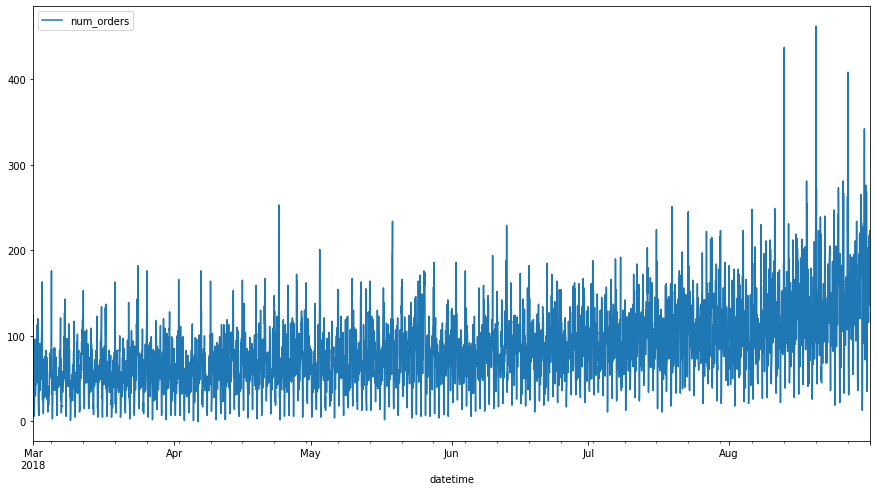

In [11]:
data = data.resample('1H').sum()
data.plot(figsize=(15, 8));

### Вывод

В блоке Подготовка данных было выполнено:

В датасете 26496 строк. Пропусков обнаружено не было. Столбец с датами был переведён в индексы. Проведено ресемплирование по часу и построен график, по которому было принято решение рассматривать данные за меньший промежуток времени.

## Анализ

Построим скользящую среднюю с окном 100

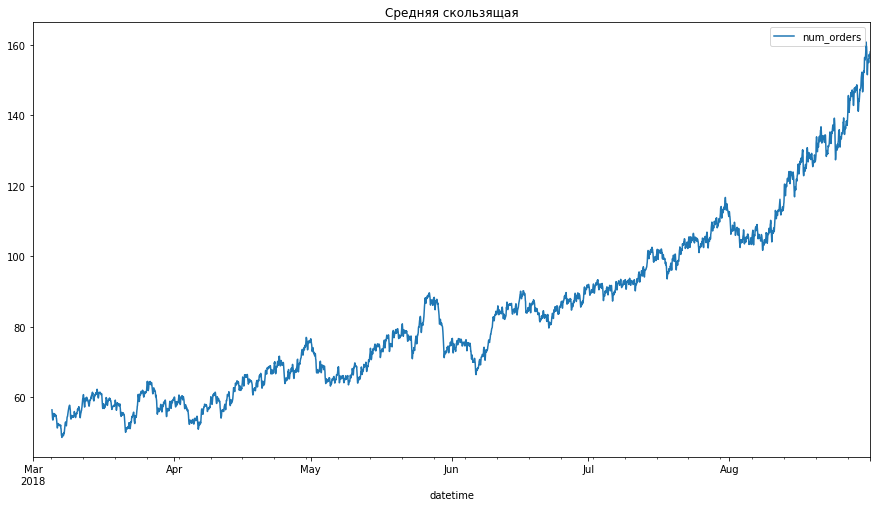

In [12]:
data.rolling(100).mean().plot(figsize=(15, 8), title='Средняя скользящая');

Со скользащей средней уже виден восходящий тренд

Анализ временных рядов

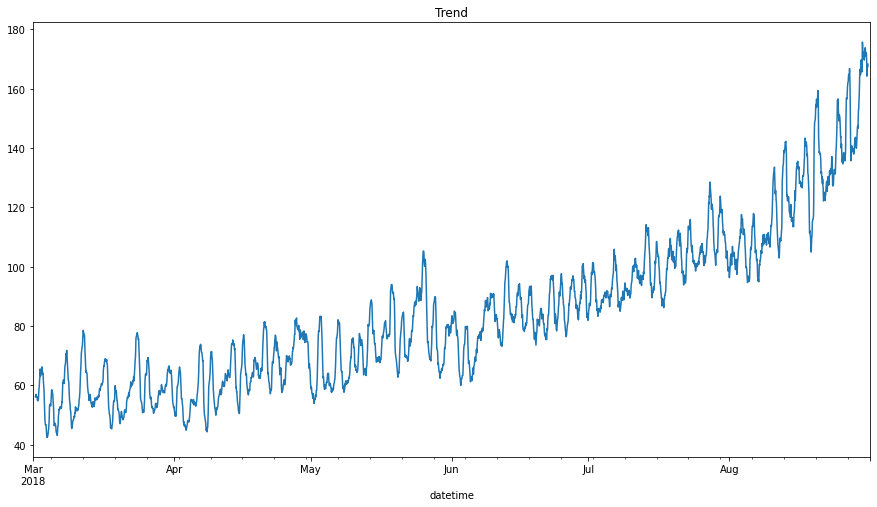

In [13]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(figsize=(15, 8), title='Trend');

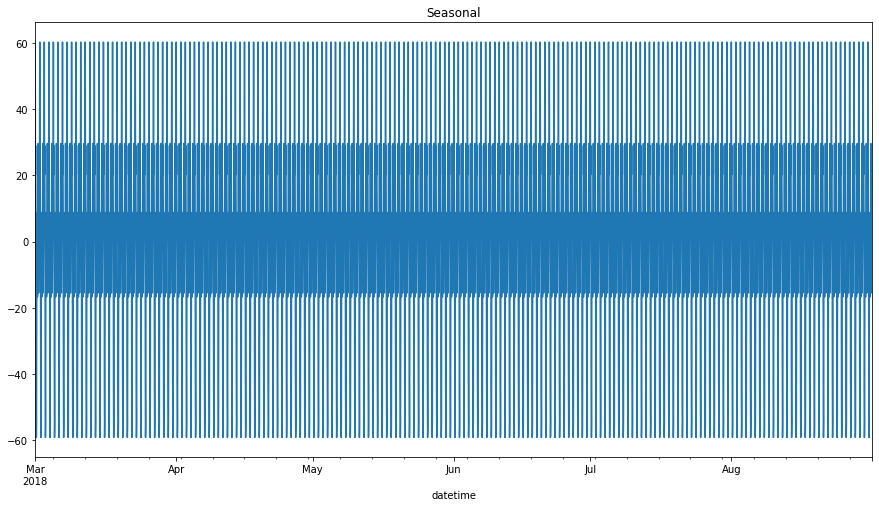

In [14]:
decomposed.seasonal.plot(figsize=(15, 8), title='Seasonal');

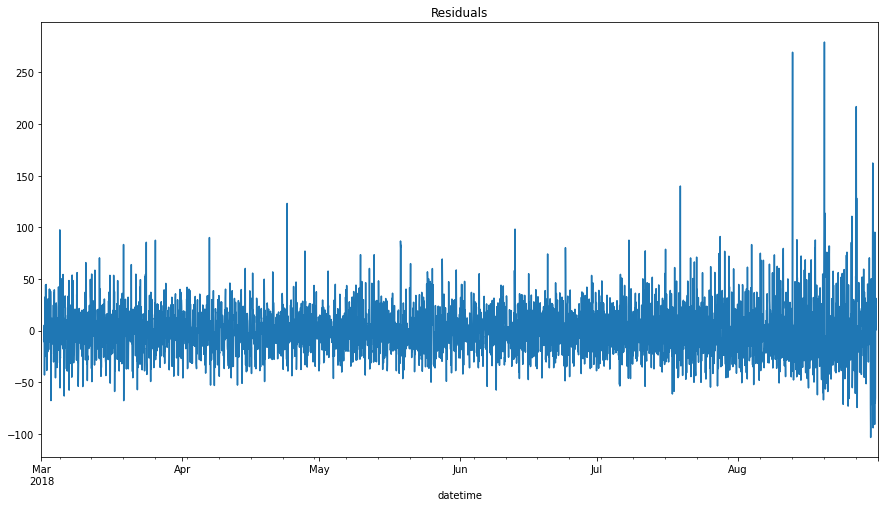

In [15]:
decomposed.resid.plot(figsize=(15, 8), title='Residuals');

Гграфики имеют большую частотность, построим такие же графики для меньшего периода.

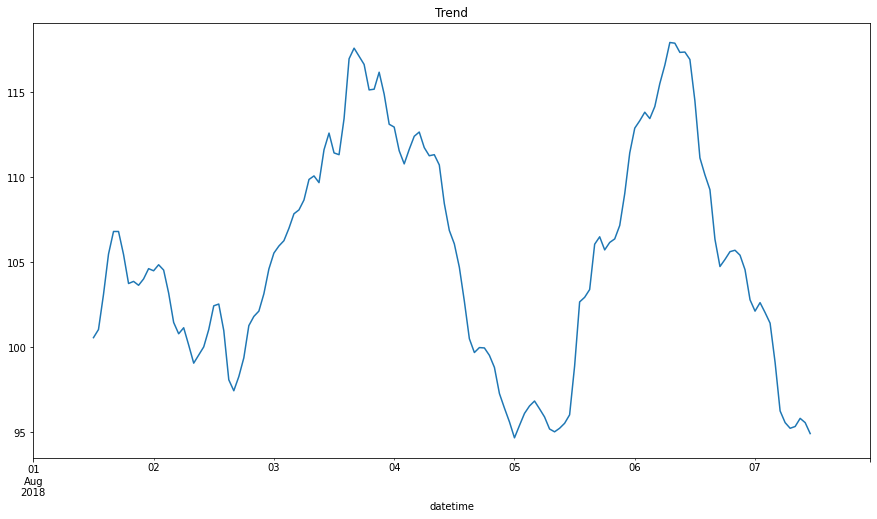

In [16]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-07'])
decomposed.trend.plot(figsize=(15, 8), title='Trend');

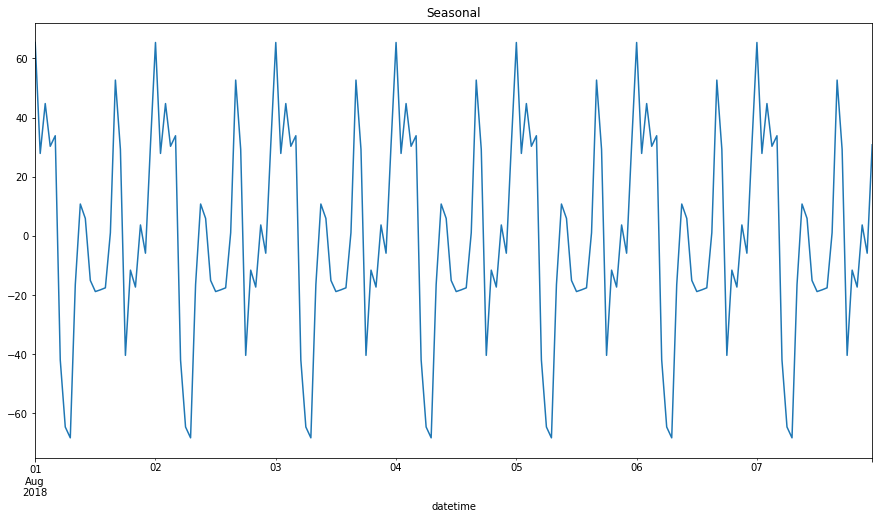

In [17]:
decomposed.seasonal.plot(figsize=(15, 8), title='Seasonal');

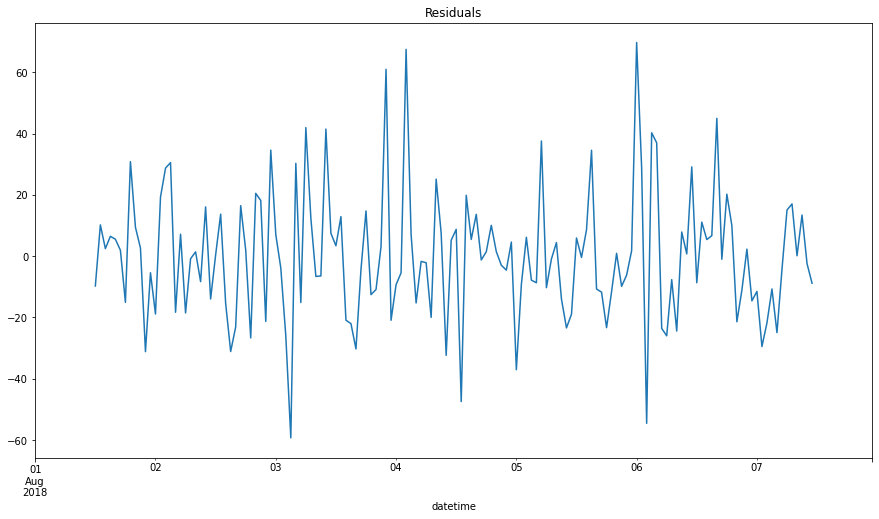

In [18]:
decomposed.resid.plot(figsize=(15, 8), title='Residuals');

Вечер - самый активный сезон заказа такси. Ночью показатель стремится к нулю.

## Обучение

Напишем функцию создания признаков. Функция будет создавать год, месяц, день и день недели, а также лаги и скользящее среднее.

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Вызовем функцию для нашего датасета, 24 лагов и 100-го скользящего среднего.

In [20]:
make_features(data, 24, 100)

In [21]:
data.isna().sum()

num_orders        0
year              0
month             0
day               0
dayofweek         0
lag_1             1
lag_2             2
lag_3             3
lag_4             4
lag_5             5
lag_6             6
lag_7             7
lag_8             8
lag_9             9
lag_10           10
lag_11           11
lag_12           12
lag_13           13
lag_14           14
lag_15           15
lag_16           16
lag_17           17
lag_18           18
lag_19           19
lag_20           20
lag_21           21
lag_22           22
lag_23           23
lag_24           24
rolling_mean    100
dtype: int64

Удалим пропущенные значения

In [22]:
data = data.dropna()

In [23]:
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,2018,3,5,0,51.0,32.0,176.0,86.0,68.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,2018,3,5,0,34.0,51.0,32.0,176.0,86.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,2018,3,5,0,16.0,34.0,51.0,32.0,176.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,2018,3,5,0,3.0,16.0,34.0,51.0,32.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,2018,3,5,0,14.0,3.0,16.0,34.0,51.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


Разделим датасет на обучающую и тестовую выборку, а также на признаки и целевой признак.

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [25]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 29)
(432, 29)
(3884,)
(432,)


Создадим функцию для вычисления rmse

In [26]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

RMSE_score = make_scorer(RMSE, greater_is_better=False)

**LinearRegression**

Вместо кросс-валидации будем использовать TimeSeriesSplit()

In [27]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
model_lr.fit(features_train, target_train)
model_lr_cv_score = pd.Series(cross_val_score(model_lr,features_train,target_train,scoring=RMSE_score,cv=cv)).mean()*(-1)
print(model_lr_cv_score)

28.275898753655373


RMSE Линейной регресси на обучающей выборке составила **28**

**RandomForestRegressor**

Здесь используем подбор параметров с помощью GridSearchCV

In [28]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
param = {'n_estimators': [100, 200, 300], 'max_depth': [9]}
model_rf = RandomForestRegressor(random_state=12345)
tuning_model_rf=GridSearchCV(model_rf, param, scoring=RMSE_score, cv=cv)
tuning_model_rf.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7efedfe817b0>,
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [9], 'n_estimators': [100, 200, 300]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [29]:
rf_param = tuning_model_rf.best_params_
rf_score = tuning_model_rf.score(features_train, target_train) * (-1)
print(rf_param)
print(rf_score)

{'max_depth': 9, 'n_estimators': 300}
16.21487971731585


RMSE Случайного леса составила **16** с параметрами `max_depth` = 9, `n_estimators` = 300

**CatBoostRegressor**

In [30]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
param = {'learning_rate': [0.03, 0.1],'depth': [4, 6, 10]}
model_cb = cb.CatBoostRegressor()
turing_model_cb = GridSearchCV(model_cb, param, scoring=RMSE_score, cv=cv)
turing_model_cb.fit(features_train, target_train, verbose=100)

0:	learn: 28.8547429	total: 52.8ms	remaining: 52.7s
100:	learn: 18.1994024	total: 241ms	remaining: 2.15s
200:	learn: 16.2825116	total: 411ms	remaining: 1.64s
300:	learn: 15.0781771	total: 584ms	remaining: 1.36s
400:	learn: 13.9105862	total: 757ms	remaining: 1.13s
500:	learn: 12.8555891	total: 932ms	remaining: 928ms
600:	learn: 11.9949258	total: 1.15s	remaining: 762ms
700:	learn: 11.1144727	total: 1.35s	remaining: 577ms
800:	learn: 10.4435977	total: 1.53s	remaining: 380ms
900:	learn: 9.8094890	total: 1.75s	remaining: 192ms
999:	learn: 9.2428678	total: 1.96s	remaining: 0us
0:	learn: 31.8971050	total: 4.43ms	remaining: 4.42s
100:	learn: 20.4293611	total: 328ms	remaining: 2.92s
200:	learn: 18.7120777	total: 577ms	remaining: 2.29s
300:	learn: 17.5993542	total: 792ms	remaining: 1.84s
400:	learn: 16.7013235	total: 1000ms	remaining: 1.49s
500:	learn: 15.9508179	total: 1.28s	remaining: 1.27s
600:	learn: 15.2953652	total: 1.48s	remaining: 981ms
700:	learn: 14.6979112	total: 1.73s	remaining: 737m

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7efee1dd42e0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7efedfa20790>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [31]:
cb_param = turing_model_cb.best_params_
cb_score = turing_model_cb.score(features_train, target_train) * (-1)
print(cb_param)
print(cb_score)

{'depth': 6, 'learning_rate': 0.03}
14.329875490541367


RMSE CarBoostRegressor составила **14** с параметрами `depth` = 6, `learning_rate` = 0.03

**LGBMRegressor**

In [32]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
param = {'n_estimators': [100, 200, 300], 'num_leaves': [7, 15, 31]}
model_lgb = lgb.LGBMRegressor(random_state=12345)
turing_model_lgb = GridSearchCV(model_lgb, param, scoring=RMSE_score, cv=cv)
turing_model_lgb.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7efee1dd43c0>,
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'n_estimators': [100, 200, 300],
                         'num_leaves': [7, 15, 31]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [33]:
lgb_param = turing_model_lgb.best_params_
lgb_score = turing_model_lgb.score(features_train, target_train) * (-1)
print(lgb_param)
print(lgb_score)

{'n_estimators': 100, 'num_leaves': 7}
20.461617972685467


RMSE LGBRegressor составила **20** с параметрами `n_estimators` = 100, `num_leaves` = 7

На обучающей выборке лучшей моделью оказалась CarBoostRegressor, среднеквадратичная ошибка составила *14*

## Тестирование

Проведем тестирование лучшей модели.

In [34]:
cb_model = cb.CatBoostRegressor(depth=6, learning_rate=0.03)
cb_model.fit(features_train, target_train)
cb_model_predictions = cb_model.predict(features_test)

cb_RMSE = RMSE(target_test, cb_model_predictions)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

0:	learn: 38.1916728	total: 9.03ms	remaining: 9.02s
1:	learn: 37.6659904	total: 16.3ms	remaining: 8.12s
2:	learn: 37.1760937	total: 23.9ms	remaining: 7.95s
3:	learn: 36.7344196	total: 32.1ms	remaining: 8.01s
4:	learn: 36.3042098	total: 39ms	remaining: 7.76s
5:	learn: 35.8600094	total: 48ms	remaining: 7.95s
6:	learn: 35.4416958	total: 56.2ms	remaining: 7.97s
7:	learn: 35.0367408	total: 62.7ms	remaining: 7.78s
8:	learn: 34.6796022	total: 70.1ms	remaining: 7.72s
9:	learn: 34.2867596	total: 76.9ms	remaining: 7.61s
10:	learn: 33.9173331	total: 83.3ms	remaining: 7.49s
11:	learn: 33.5539129	total: 89.8ms	remaining: 7.39s
12:	learn: 33.2030288	total: 96.9ms	remaining: 7.36s
13:	learn: 32.9200346	total: 104ms	remaining: 7.3s
14:	learn: 32.5917493	total: 111ms	remaining: 7.26s
15:	learn: 32.2805158	total: 117ms	remaining: 7.18s
16:	learn: 31.9777418	total: 124ms	remaining: 7.14s
17:	learn: 31.6856264	total: 130ms	remaining: 7.1s
18:	learn: 31.4208921	total: 139ms	remaining: 7.18s
19:	learn: 31.1

Все модели показали среднеквадратичную ошибку менбше 48, но лучшей моделью оказалась CatBoostRegressor со значением RMSE 41.

Построим график предсказаний и реальных значений за весь период и меньший.

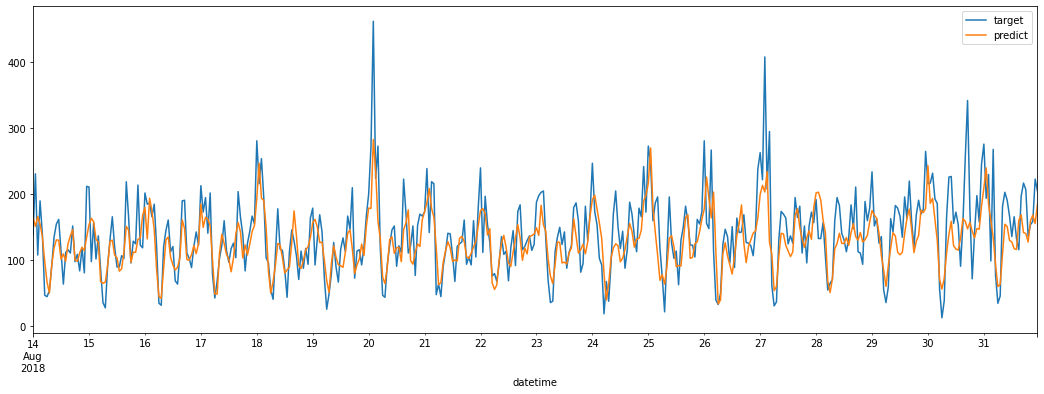

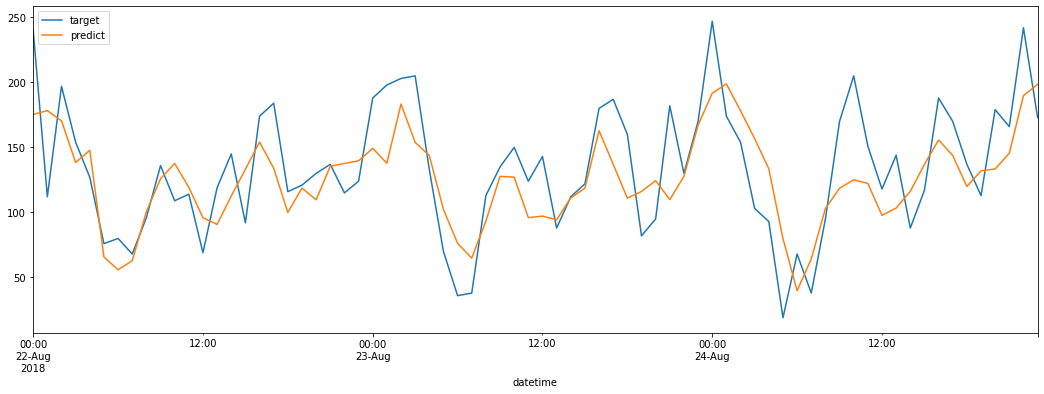

In [36]:
model_data = pd.DataFrame({"target":target_test, "predict":cb_model_predictions})
model_data.plot(figsize=(18, 6));
model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6));

## Вывод

В данной работе были проведены следующие действия:

- В первом блоке была проведена подготовка данных: изменен тип данных, проведено ресемплирование;
- При анализе данных были построены графики со средним скользящим, графики для анализа временных рядов (тренд, сезонность) и было определено, что большинство заказов такси приходится на вечер, ночью количество заказов стремится к нулю;
- В блоке обучения с помощью функций были созданы признаки (год, месяц, день, день недели, лаги и скользящее среднее), обучены 4 модели: Линейная регрессия, Случайный лес, CatBoostRegressor и LGBRegressor и выявлены rmse на наилучших параметрах. Лучшей моделью оказалась CatBoostRegressor с ошибкой 14
- На тесте модель CatBoostRegressor показала результат RMSE = 41